<a href="https://colab.research.google.com/github/jordantab/11785-assignment-part2s/blob/main/HW2P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Libraries

In [1]:
!nvidia-smi # Run this to see what GPU you have

Sun Oct  6 18:33:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.0/311.0 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 4.1 MB/s eta 0:00:00


In [3]:
import torch
from torchsummary import summary
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [4]:
from google.colab import drive # Link to your drive if you are not using Colab with GCP
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

Mounted at /content/drive


# Kaggle

In [5]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"jordantab","key":"6012317c8cbe2756d1bf461f146b1d6e"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73248 sha256=86292f0bb7fb30eefae150377bb7421fd8dc8c24b11bd3cae69d79a35f9abdbb
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [6]:
# # Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2024
!unzip -qo '11785-hw-2-p-2-face-verification-fall-2024.zip' -d '/content/data'

100% 2.75G/2.75G [01:12<00:00, 42.6MB/s]
100% 2.75G/2.75G [01:12<00:00, 40.9MB/s]


# Config

In [8]:
run_name = "resnet34-1"

checkpoint_dir = f"/content/drive/My Drive/hw2p2/checkpoints/{run_name}"
os.makedirs(checkpoint_dir, exist_ok=True)

config = {
    'batch_size': 256, # Increase this if your GPU can handle it
    'lr':  0.1,
    'epochs': 50, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'data_dir': "data/11-785-f24-hw2p2-verification/cls_data", #TODO
    'data_ver_dir': "data/11-785-f24-hw2p2-verification/ver_data", #TODO
    'checkpoint_dir': checkpoint_dir, #TODO
    'run_name': run_name
    # Include other parameters as needed.
}

In [ ]:
print(os.path.exists('data/11-785-f24-hw2p2-verification'))

# Dataset

## Dataset Class for doing Image Verification

In [9]:
class ImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2, match = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2), int(match)

In [10]:
class TestImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2 = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2)

## Create Dataloaders for Image Recognition

In [11]:
data_dir = config['data_dir']
# train_dir = os.path.join(data_dir)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'dev')

# train transforms
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112), # Why are we resizing the Image?
    torchvision.transforms.TrivialAugmentWide(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])

# val transforms
val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])


# get datasets
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=config["batch_size"],
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=8,
                                            sampler=None)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=False,
                                          num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
data_dir = config['data_ver_dir']

# get datasets

# TODO: Add your validation pair txt file
pair_dataset = ImagePairDataset(data_dir, csv_file='data/11-785-f24-hw2p2-verification/val_pairs.txt', transform=val_transforms)
pair_dataloader = torch.utils.data.DataLoader(pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# TODO: Add your validation pair txt file
test_pair_dataset = TestImagePairDataset(data_dir, csv_file='data/11-785-f24-hw2p2-verification/test_pairs.txt', transform=val_transforms)
test_pair_dataloader = torch.utils.data.DataLoader(test_pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# EDA and Viz

In [13]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  256
Train batches        :  1686
Val batches          :  169


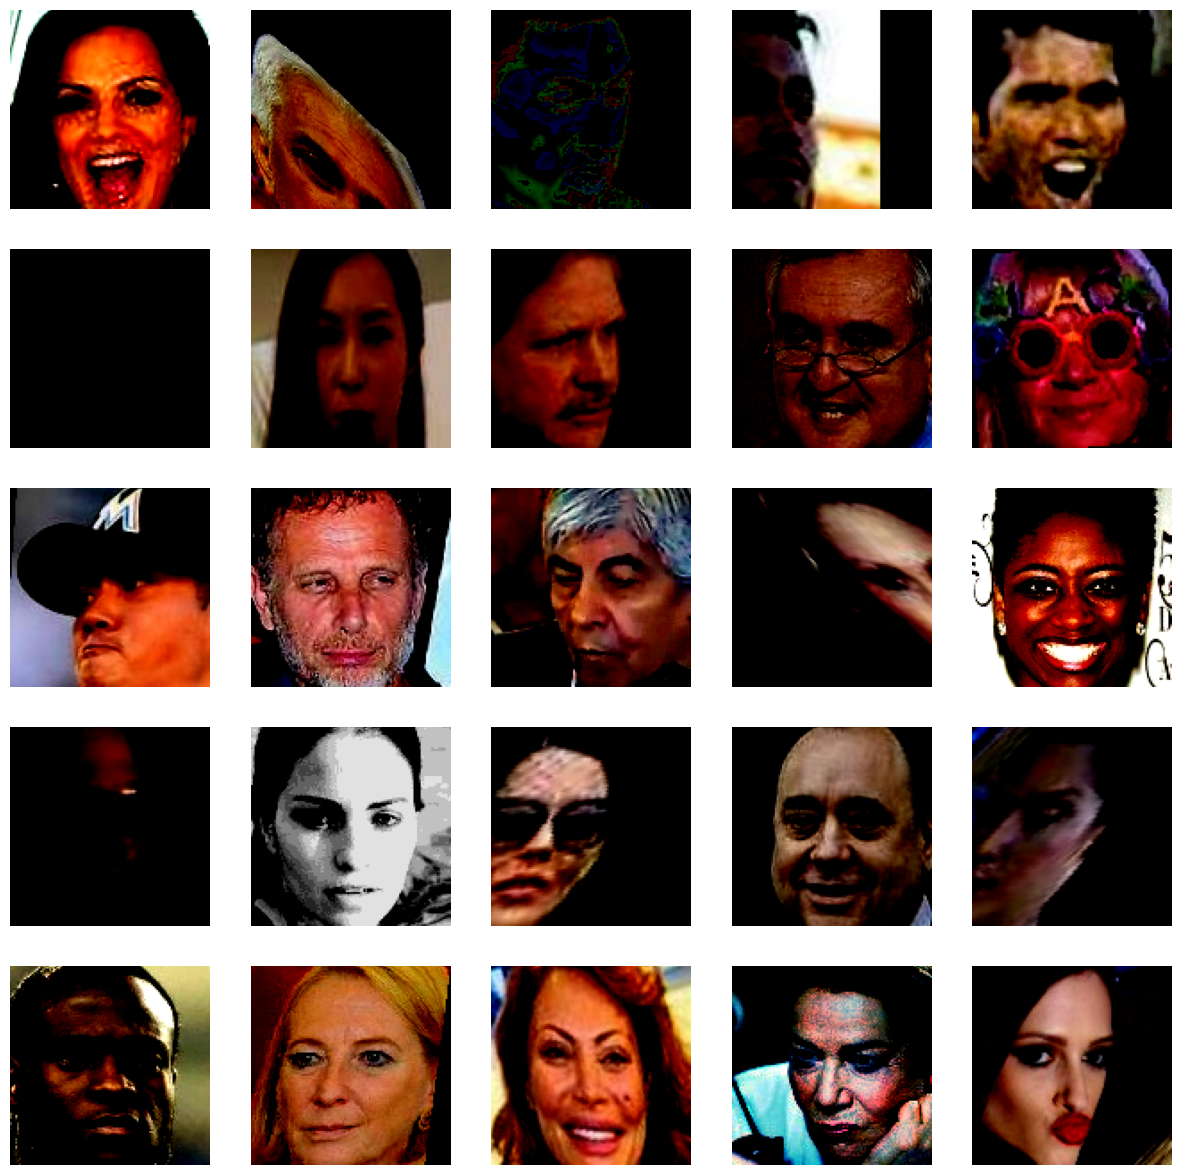

In [14]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(train_dir, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [15]:
# Residual Block for ResNet

class ResidualBlock(torch.nn.Module):
  expansion = 1

  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super(ResidualBlock, self).__init__()
    self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
    self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1), torch.nn.BatchNorm2d(out_channels))
    self.downsample = downsample
    self.relu = torch.nn.ReLU()

  def forward(self, x):
    residual = x

    # First convolutional layer
    out = self.conv1(x)

    # Second convolutional layer
    out = self.conv2(out)

    if self.downsample is not None:
      residual = self.downsample(x)

    out += residual
    out = self.relu(out)

    return out

In [16]:
# ResNet Architecture stacking together blocks
class ResNet(torch.nn.Module):
  def __init__(self, block, layers, num_classes=8631):
    super(ResNet, self).__init__()
    self.in_channels = 64

    # Initial convolution and pooling layers
    self.conv1 = torch.nn.Sequential(
      torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
      torch.nn.BatchNorm2d(64),
      torch.nn.ReLU())
    self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # Residual blocks
    self.layer1 = self._make_layer(block, 64, layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

    # Average pooling and fully connected layer
    self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
    self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, out_channels, blocks, stride=1):
    downsample = None
    if stride != 1 or self.in_channels != out_channels:
      downsample = torch.nn.Sequential(
          torch.nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=
                          1, stride=stride),
          torch.nn.BatchNorm2d(out_channels * block.expansion)
      )

    layers = []
    layers.append(block(self.in_channels, out_channels, stride, downsample))
    self.in_channels = out_channels * block.expansion
    for _ in range(1, blocks):
      layers.append(block(self.in_channels, out_channels))

    return torch.nn.Sequential(*layers)

  def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        feats = x
        out = self.fc(x)

        return {"feats": feats, "out": out}

model = ResNet(ResidualBlock, [3,4,6,3]).to(DEVICE)
summary(model, (3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,472
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]          36,928
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,928
       BatchNorm2d-9           [-1, 64, 28, 28]             128
             ReLU-10           [-1, 64, 28, 28]               0
    ResidualBlock-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          36,928
      BatchNorm2d-13           [-1, 64, 28, 28]             128
             ReLU-14           [-1, 64,

In [17]:
# # TODO: Fill out the model definition below

# class Network(torch.nn.Module):

#     def __init__(self, num_classes=8631):
#         super().__init__()

#         self.backbone = torch.nn.Sequential(
#             # First Layer
#             torch.nn.Conv2d(3, 64, kernel_size=7, stride=4, padding=3),
#             torch.nn.BatchNorm2d(64),
#             torch.nn.ReLU(),

#             # Second Layer
#             torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
#             torch.nn.BatchNorm2d(128),
#             torch.nn.ReLU(),

#             # Third Layer
#             torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
#             torch.nn.BatchNorm2d(256),
#             torch.nn.ReLU(),

#             # Fourth Layer
#             torch.nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
#             torch.nn.BatchNorm2d(512),
#             torch.nn.ReLU(),

#             # Fifth Layer
#             torch.nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
#             torch.nn.BatchNorm2d(1024),
#             torch.nn.ReLU(),

#             # Pooling Layer
#             torch.nn.AdaptiveAvgPool2d(1),

#             # Flatten
#             torch.nn.Flatten()
#             )


#         self.cls_layer = torch.nn.Linear(in_features=1024, out_features=num_classes)

#     def forward(self, x):
#         feats = self.backbone(x)
#         out = self.cls_layer(feats)
#         return {"feats": feats, "out": out}

# # Initialize your model
# model = Network().to(DEVICE)
# summary(model, (3, 112, 112))

In [18]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss()

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr= config['lr'])
# SGD(model.parameters(), lr=0.01, momentum=0.9)
# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

<ipython-input-18-592e98ea0fc3>:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Metrics

In [19]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [20]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [21]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [22]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
            outputs = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['out'], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    if lr_scheduler is not None:
        lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [23]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [24]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [25]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC'], metric_dict['EER']

# WandB

In [26]:
wandb.login(key="4c68592a14802648ff3220711294d6e5fe7d272f") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [27]:
# Create your wandb run
run = wandb.init(
    name = config['run_name'], ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: Currently logged in as: jordantab20 (jordantab20-carnegie-mellon-university). Use `wandb login --relogin` to force relogin


# Checkpointing and Loading Model

In [28]:
# Uncomment the line for saving the scheduler save dict if you are using a scheduler
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

# Experiments

In [29]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })
            scheduler.step(valid_loss)

        # retrieval validation
        valid_ret_acc, valid_eer = valid_epoch_ver(model, pair_dataloader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc,
            'valid_eer': valid_eer
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 1/50: 
Train Cls. Acc 0.0202%	 Train Cls. Loss 9.0114	 Learning Rate 0.0999


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 0.0416%	 Val Cls. Loss 8.7421


{'ACC': 56.5, 'EER': 44.597249508779726, 'AUC': 57.44221127645357, 'TPRs': [('TPR@FPR=1e-4', 0.20366598778004072), ('TPR@FPR=5e-4', 0.20366598778004072), ('TPR@FPR=1e-3', 0.20366598778004072), ('TPR@FPR=5e-3', 0.8146639511201629), ('TPR@FPR=5e-2', 8.757637474541752)]}
Val Ret. Acc 56.5000%
Saved epoch model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best classification model
Saved best retrieval model

Epoch 2/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 2/50: 
Train Cls. Acc 0.2749%	 Train Cls. Loss 8.0427	 Learning Rate 0.0909


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 0.9597%	 Val Cls. Loss 7.0850


{'ACC': 66.5, 'EER': 34.419551934830324, 'AUC': 70.8477546725139, 'TPRs': [('TPR@FPR=1e-4', 2.240325865580448), ('TPR@FPR=5e-4', 2.240325865580448), ('TPR@FPR=1e-3', 2.240325865580448), ('TPR@FPR=5e-3', 3.6659877800407332), ('TPR@FPR=5e-2', 20.162932790224033)]}
Val Ret. Acc 66.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 3/50: 
Train Cls. Acc 2.6439%	 Train Cls. Loss 6.5588	 Learning Rate 0.0937


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 2.8735%	 Val Cls. Loss 6.7916


{'ACC': 71.6, 'EER': 29.862475441942433, 'AUC': 77.14859614515103, 'TPRs': [('TPR@FPR=1e-4', 7.128309572301425), ('TPR@FPR=5e-4', 7.128309572301425), ('TPR@FPR=1e-3', 7.128309572301425), ('TPR@FPR=5e-3', 10.183299389002038), ('TPR@FPR=5e-2', 32.9938900203666)]}
Val Ret. Acc 71.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 4/50: 
Train Cls. Acc 9.6441%	 Train Cls. Loss 5.3998	 Learning Rate 0.0941


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 9.6804%	 Val Cls. Loss 5.3763


{'ACC': 71.0, 'EER': 29.469548133581004, 'AUC': 78.88155762467039, 'TPRs': [('TPR@FPR=1e-4', 3.054989816700611), ('TPR@FPR=5e-4', 3.054989816700611), ('TPR@FPR=1e-3', 3.054989816700611), ('TPR@FPR=5e-3', 9.572301425661914), ('TPR@FPR=5e-2', 33.604887983706725)]}
Val Ret. Acc 71.0000%
Saved epoch model
Saved best classification model

Epoch 5/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 5/50: 
Train Cls. Acc 19.5554%	 Train Cls. Loss 4.4956	 Learning Rate 0.0960


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 23.0248%	 Val Cls. Loss 4.0576


{'ACC': 70.8, 'EER': 29.46954813358874, 'AUC': 78.14491895374101, 'TPRs': [('TPR@FPR=1e-4', 5.295315682281059), ('TPR@FPR=5e-4', 5.295315682281059), ('TPR@FPR=1e-3', 5.295315682281059), ('TPR@FPR=5e-3', 6.517311608961303), ('TPR@FPR=5e-2', 34.21588594704684)]}
Val Ret. Acc 70.8000%
Saved epoch model
Saved best classification model

Epoch 6/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 6/50: 
Train Cls. Acc 30.0141%	 Train Cls. Loss 3.7667	 Learning Rate 0.0975


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 31.8223%	 Val Cls. Loss 3.5873


{'ACC': 72.8, 'EER': 27.291242362480055, 'AUC': 79.09722750171055, 'TPRs': [('TPR@FPR=1e-4', 3.2586558044806515), ('TPR@FPR=5e-4', 3.2586558044806515), ('TPR@FPR=1e-3', 3.2586558044806515), ('TPR@FPR=5e-3', 7.128309572301425), ('TPR@FPR=5e-2', 36.456211812627295)]}
Val Ret. Acc 72.8000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 7/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 7/50: 
Train Cls. Acc 39.2525%	 Train Cls. Loss 3.1953	 Learning Rate 0.0979


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 34.6184%	 Val Cls. Loss 3.4074


{'ACC': 70.8, 'EER': 30.753564154786154, 'AUC': 77.5059119154606, 'TPRs': [('TPR@FPR=1e-4', 7.128309572301425), ('TPR@FPR=5e-4', 7.128309572301425), ('TPR@FPR=1e-3', 7.128309572301425), ('TPR@FPR=5e-3', 9.979633401221996), ('TPR@FPR=5e-2', 31.771894093686353)]}
Val Ret. Acc 70.8000%
Saved epoch model
Saved best classification model

Epoch 8/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 8/50: 
Train Cls. Acc 46.3556%	 Train Cls. Loss 2.7672	 Learning Rate 0.0981


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 43.2437%	 Val Cls. Loss 2.8532


{'ACC': 75.0, 'EER': 26.680244399185288, 'AUC': 82.11380487277877, 'TPRs': [('TPR@FPR=1e-4', 6.109979633401222), ('TPR@FPR=5e-4', 6.109979633401222), ('TPR@FPR=1e-3', 6.109979633401222), ('TPR@FPR=5e-3', 14.25661914460285), ('TPR@FPR=5e-2', 43.58452138492871)]}
Val Ret. Acc 75.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 9/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 9/50: 
Train Cls. Acc 52.3509%	 Train Cls. Loss 2.4275	 Learning Rate 0.0985


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 50.0668%	 Val Cls. Loss 2.4834


{'ACC': 76.1, 'EER': 24.643584521398328, 'AUC': 83.11692988528283, 'TPRs': [('TPR@FPR=1e-4', 12.423625254582484), ('TPR@FPR=5e-4', 12.423625254582484), ('TPR@FPR=1e-3', 12.423625254582484), ('TPR@FPR=5e-3', 23.014256619144604), ('TPR@FPR=5e-2', 42.973523421588595)]}
Val Ret. Acc 76.1000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 10/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 10/50: 
Train Cls. Acc 57.1618%	 Train Cls. Loss 2.1554	 Learning Rate 0.0988


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 52.2496%	 Val Cls. Loss 2.3732


{'ACC': 76.2, 'EER': 24.557956778060113, 'AUC': 83.37821454151144, 'TPRs': [('TPR@FPR=1e-4', 2.8513238289205702), ('TPR@FPR=5e-4', 2.8513238289205702), ('TPR@FPR=1e-3', 2.8513238289205702), ('TPR@FPR=5e-3', 15.274949083503056), ('TPR@FPR=5e-2', 43.17718940936864)]}
Val Ret. Acc 76.2000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 11/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 11/50: 
Train Cls. Acc 61.0394%	 Train Cls. Loss 1.9368	 Learning Rate 0.0989


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 60.0834%	 Val Cls. Loss 1.9504


{'ACC': 76.5, 'EER': 25.54027504923866, 'AUC': 82.72200192862486, 'TPRs': [('TPR@FPR=1e-4', 2.8513238289205702), ('TPR@FPR=5e-4', 2.8513238289205702), ('TPR@FPR=1e-3', 2.8513238289205702), ('TPR@FPR=5e-3', 16.700610997963338), ('TPR@FPR=5e-2', 45.010183299389)]}
Val Ret. Acc 76.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 12/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 12/50: 
Train Cls. Acc 64.2873%	 Train Cls. Loss 1.7569	 Learning Rate 0.0991


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 62.2779%	 Val Cls. Loss 1.8372


{'ACC': 75.7, 'EER': 24.643584521384927, 'AUC': 82.63557392595202, 'TPRs': [('TPR@FPR=1e-4', 10.79429735234216), ('TPR@FPR=5e-4', 10.79429735234216), ('TPR@FPR=1e-3', 10.79429735234216), ('TPR@FPR=5e-3', 18.329938900203665), ('TPR@FPR=5e-2', 43.38085539714868)]}
Val Ret. Acc 75.7000%
Saved epoch model
Saved best classification model

Epoch 13/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 13/50: 
Train Cls. Acc 67.0504%	 Train Cls. Loss 1.6068	 Learning Rate 0.0992


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 65.1815%	 Val Cls. Loss 1.7072


{'ACC': 77.3, 'EER': 23.42158859470469, 'AUC': 84.17767356623546, 'TPRs': [('TPR@FPR=1e-4', 9.979633401221996), ('TPR@FPR=5e-4', 9.979633401221996), ('TPR@FPR=1e-3', 9.979633401221996), ('TPR@FPR=5e-3', 24.643584521384927), ('TPR@FPR=5e-2', 48.472505091649694)]}
Val Ret. Acc 77.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 14/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 14/50: 
Train Cls. Acc 69.4655%	 Train Cls. Loss 1.4724	 Learning Rate 0.0993


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 68.8588%	 Val Cls. Loss 1.5196


{'ACC': 79.5, 'EER': 20.825147347758072, 'AUC': 86.3471764851812, 'TPRs': [('TPR@FPR=1e-4', 4.480651731160896), ('TPR@FPR=5e-4', 4.480651731160896), ('TPR@FPR=1e-3', 4.480651731160896), ('TPR@FPR=5e-3', 13.441955193482688), ('TPR@FPR=5e-2', 46.84317718940937)]}
Val Ret. Acc 79.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 15/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 15/50: 
Train Cls. Acc 71.3914%	 Train Cls. Loss 1.3674	 Learning Rate 0.0994


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 70.4467%	 Val Cls. Loss 1.4379


{'ACC': 76.3, 'EER': 24.643584521384938, 'AUC': 83.932794225329, 'TPRs': [('TPR@FPR=1e-4', 7.535641547861507), ('TPR@FPR=5e-4', 7.535641547861507), ('TPR@FPR=1e-3', 7.535641547861507), ('TPR@FPR=5e-3', 22.606924643584524), ('TPR@FPR=5e-2', 43.9918533604888)]}
Val Ret. Acc 76.3000%
Saved epoch model
Saved best classification model

Epoch 16/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 16/50: 
Train Cls. Acc 73.2955%	 Train Cls. Loss 1.2657	 Learning Rate 0.0994


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 69.2241%	 Val Cls. Loss 1.4989


{'ACC': 76.5, 'EER': 24.643584521384927, 'AUC': 84.48097183487448, 'TPRs': [('TPR@FPR=1e-4', 10.9979633401222), ('TPR@FPR=5e-4', 10.9979633401222), ('TPR@FPR=1e-3', 10.9979633401222), ('TPR@FPR=5e-3', 20.773930753564155), ('TPR@FPR=5e-2', 51.5274949083503)]}
Val Ret. Acc 76.5000%


Saved epoch model

Epoch 17/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 17/50: 
Train Cls. Acc 74.9180%	 Train Cls. Loss 1.1836	 Learning Rate 0.0994


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 73.1129%	 Val Cls. Loss 1.3142


{'ACC': 77.9, 'EER': 23.217922606924652, 'AUC': 84.79667412241565, 'TPRs': [('TPR@FPR=1e-4', 8.961303462321792), ('TPR@FPR=5e-4', 8.961303462321792), ('TPR@FPR=1e-3', 8.961303462321792), ('TPR@FPR=5e-3', 15.478615071283095), ('TPR@FPR=5e-2', 42.56619144602851)]}
Val Ret. Acc 77.9000%
Saved epoch model
Saved best classification model

Epoch 18/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 18/50: 
Train Cls. Acc 76.3222%	 Train Cls. Loss 1.1094	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 72.5263%	 Val Cls. Loss 1.3431


{'ACC': 78.9, 'EER': 22.606924643585195, 'AUC': 84.59540891248764, 'TPRs': [('TPR@FPR=1e-4', 9.775967413441954), ('TPR@FPR=5e-4', 9.775967413441954), ('TPR@FPR=1e-3', 9.775967413441954), ('TPR@FPR=5e-3', 24.643584521384927), ('TPR@FPR=5e-2', 47.04684317718941)]}
Val Ret. Acc 78.9000%
Saved epoch model

Epoch 19/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 19/50: 
Train Cls. Acc 77.6125%	 Train Cls. Loss 1.0421	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 70.0503%	 Val Cls. Loss 1.4774


{'ACC': 75.9, 'EER': 24.236252545857255, 'AUC': 82.75121139249116, 'TPRs': [('TPR@FPR=1e-4', 7.128309572301425), ('TPR@FPR=5e-4', 7.128309572301425), ('TPR@FPR=1e-3', 7.128309572301425), ('TPR@FPR=5e-3', 15.478615071283095), ('TPR@FPR=5e-2', 41.955193482688394)]}
Val Ret. Acc 75.9000%
Saved epoch model

Epoch 20/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 20/50: 
Train Cls. Acc 78.7680%	 Train Cls. Loss 0.9791	 Learning Rate 0.0994


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 73.2937%	 Val Cls. Loss 1.3202


{'ACC': 76.8, 'EER': 23.96856581524489, 'AUC': 84.12605684241694, 'TPRs': [('TPR@FPR=1e-4', 2.0366598778004072), ('TPR@FPR=5e-4', 2.0366598778004072), ('TPR@FPR=1e-3', 2.0366598778004072), ('TPR@FPR=5e-3', 20.570264765784113), ('TPR@FPR=5e-2', 43.38085539714868)]}
Val Ret. Acc 76.8000%
Saved epoch model
Saved best classification model

Epoch 21/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 21/50: 
Train Cls. Acc 79.8310%	 Train Cls. Loss 0.9293	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 74.0165%	 Val Cls. Loss 1.2868


{'ACC': 76.4, 'EER': 23.625254582484878, 'AUC': 83.84236492623609, 'TPRs': [('TPR@FPR=1e-4', 10.9979633401222), ('TPR@FPR=5e-4', 10.9979633401222), ('TPR@FPR=1e-3', 10.9979633401222), ('TPR@FPR=5e-3', 22.403258655804482), ('TPR@FPR=5e-2', 48.87983706720978)]}
Val Ret. Acc 76.4000%
Saved epoch model
Saved best classification model

Epoch 22/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 22/50: 
Train Cls. Acc 80.8132%	 Train Cls. Loss 0.8796	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 73.5369%	 Val Cls. Loss 1.3197


{'ACC': 76.4, 'EER': 23.62525458248512, 'AUC': 83.3153941877168, 'TPRs': [('TPR@FPR=1e-4', 9.164969450101832), ('TPR@FPR=5e-4', 9.164969450101832), ('TPR@FPR=1e-3', 9.164969450101832), ('TPR@FPR=5e-3', 20.570264765784113), ('TPR@FPR=5e-2', 46.63951120162933)]}
Val Ret. Acc 76.4000%
Saved epoch model

Epoch 23/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 23/50: 
Train Cls. Acc 81.6404%	 Train Cls. Loss 0.8370	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 75.1398%	 Val Cls. Loss 1.2537


{'ACC': 77.6, 'EER': 23.625254582482935, 'AUC': 84.84669032766617, 'TPRs': [('TPR@FPR=1e-4', 3.462321792260693), ('TPR@FPR=5e-4', 3.462321792260693), ('TPR@FPR=1e-3', 3.462321792260693), ('TPR@FPR=5e-3', 23.217922606924642), ('TPR@FPR=5e-2', 51.5274949083503)]}
Val Ret. Acc 77.6000%
Saved epoch model
Saved best classification model

Epoch 24/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 24/50: 
Train Cls. Acc 82.4152%	 Train Cls. Loss 0.7989	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 74.3795%	 Val Cls. Loss 1.2825


{'ACC': 78.5, 'EER': 23.014256619144643, 'AUC': 85.40447104861974, 'TPRs': [('TPR@FPR=1e-4', 8.757637474541752), ('TPR@FPR=5e-4', 8.757637474541752), ('TPR@FPR=1e-3', 8.757637474541752), ('TPR@FPR=5e-3', 24.43991853360489), ('TPR@FPR=5e-2', 48.676171079429736)]}
Val Ret. Acc 78.5000%
Saved epoch model

Epoch 25/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 25/50: 
Train Cls. Acc 83.1924%	 Train Cls. Loss 0.7616	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 75.2197%	 Val Cls. Loss 1.2429


{'ACC': 78.5, 'EER': 21.792260692464183, 'AUC': 85.97345539954945, 'TPRs': [('TPR@FPR=1e-4', 15.274949083503056), ('TPR@FPR=5e-4', 15.274949083503056), ('TPR@FPR=1e-3', 15.274949083503056), ('TPR@FPR=5e-3', 23.421588594704684), ('TPR@FPR=5e-2', 53.15682281059063)]}
Val Ret. Acc 78.5000%
Saved epoch model
Saved best classification model

Epoch 26/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 26/50: 
Train Cls. Acc 83.8458%	 Train Cls. Loss 0.7290	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 75.8801%	 Val Cls. Loss 1.2301


{'ACC': 80.8, 'EER': 20.235756385174895, 'AUC': 87.01299220947587, 'TPRs': [('TPR@FPR=1e-4', 18.73727087576375), ('TPR@FPR=5e-4', 18.73727087576375), ('TPR@FPR=1e-3', 18.73727087576375), ('TPR@FPR=5e-3', 27.494908350305497), ('TPR@FPR=5e-2', 54.17515274949084)]}
Val Ret. Acc 80.8000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 27/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 27/50: 
Train Cls. Acc 84.6035%	 Train Cls. Loss 0.6943	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 76.3665%	 Val Cls. Loss 1.2197


{'ACC': 79.5, 'EER': 21.792260692464353, 'AUC': 86.2375409632721, 'TPRs': [('TPR@FPR=1e-4', 2.6476578411405294), ('TPR@FPR=5e-4', 2.6476578411405294), ('TPR@FPR=1e-3', 2.6476578411405294), ('TPR@FPR=5e-3', 20.570264765784113), ('TPR@FPR=5e-2', 51.93482688391039)]}
Val Ret. Acc 79.5000%
Saved epoch model
Saved best classification model

Epoch 28/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 28/50: 
Train Cls. Acc 85.0264%	 Train Cls. Loss 0.6736	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 76.3949%	 Val Cls. Loss 1.2104


{'ACC': 78.6, 'EER': 21.807465618899645, 'AUC': 85.36165717692532, 'TPRs': [('TPR@FPR=1e-4', 10.183299389002038), ('TPR@FPR=5e-4', 10.183299389002038), ('TPR@FPR=1e-3', 10.183299389002038), ('TPR@FPR=5e-3', 25.45824847250509), ('TPR@FPR=5e-2', 51.73116089613035)]}
Val Ret. Acc 78.6000%
Saved epoch model
Saved best classification model

Epoch 29/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 29/50: 
Train Cls. Acc 85.5244%	 Train Cls. Loss 0.6500	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 77.9775%	 Val Cls. Loss 1.1456


{'ACC': 78.1, 'EER': 22.606924643584524, 'AUC': 85.83260976556404, 'TPRs': [('TPR@FPR=1e-4', 12.219959266802444), ('TPR@FPR=5e-4', 12.219959266802444), ('TPR@FPR=1e-3', 12.219959266802444), ('TPR@FPR=5e-3', 17.10794297352342), ('TPR@FPR=5e-2', 53.97148676171079)]}
Val Ret. Acc 78.1000%
Saved epoch model
Saved best classification model

Epoch 30/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 30/50: 
Train Cls. Acc 86.1295%	 Train Cls. Loss 0.6218	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 77.7275%	 Val Cls. Loss 1.1455


{'ACC': 77.4, 'EER': 23.37917485263782, 'AUC': 85.55572005329725, 'TPRs': [('TPR@FPR=1e-4', 15.071283095723015), ('TPR@FPR=5e-4', 15.071283095723015), ('TPR@FPR=1e-3', 15.071283095723015), ('TPR@FPR=5e-3', 19.95926680244399), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 77.4000%


Saved epoch model

Epoch 31/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 31/50: 
Train Cls. Acc 86.5829%	 Train Cls. Loss 0.5982	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 77.4420%	 Val Cls. Loss 1.1637


{'ACC': 78.6, 'EER': 22.39685658152043, 'AUC': 86.14951244203121, 'TPRs': [('TPR@FPR=1e-4', 9.164969450101832), ('TPR@FPR=5e-4', 9.164969450101832), ('TPR@FPR=1e-3', 9.164969450101832), ('TPR@FPR=5e-3', 18.94093686354379), ('TPR@FPR=5e-2', 58.45213849287168)]}
Val Ret. Acc 78.6000%
Saved epoch model

Epoch 32/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 32/50: 
Train Cls. Acc 86.9153%	 Train Cls. Loss 0.5858	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 77.8066%	 Val Cls. Loss 1.1485


{'ACC': 78.3, 'EER': 22.200392927473377, 'AUC': 85.82220639487194, 'TPRs': [('TPR@FPR=1e-4', 16.90427698574338), ('TPR@FPR=5e-4', 16.90427698574338), ('TPR@FPR=1e-3', 16.90427698574338), ('TPR@FPR=5e-3', 28.30957230142566), ('TPR@FPR=5e-2', 52.54582484725051)]}
Val Ret. Acc 78.3000%
Saved epoch model

Epoch 33/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 33/50: 
Train Cls. Acc 87.2116%	 Train Cls. Loss 0.5694	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 77.6581%	 Val Cls. Loss 1.1731


{'ACC': 79.1, 'EER': 21.807465618902604, 'AUC': 86.07308768040845, 'TPRs': [('TPR@FPR=1e-4', 15.885947046843176), ('TPR@FPR=5e-4', 15.885947046843176), ('TPR@FPR=1e-3', 15.885947046843176), ('TPR@FPR=5e-3', 29.938900203665987), ('TPR@FPR=5e-2', 49.69450101832994)]}
Val Ret. Acc 79.1000%
Saved epoch model

Epoch 34/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 34/50: 
Train Cls. Acc 87.7227%	 Train Cls. Loss 0.5458	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 78.4711%	 Val Cls. Loss 1.1330


{'ACC': 78.7, 'EER': 22.81059063136455, 'AUC': 86.62846762351002, 'TPRs': [('TPR@FPR=1e-4', 22.19959266802444), ('TPR@FPR=5e-4', 22.19959266802444), ('TPR@FPR=1e-3', 22.19959266802444), ('TPR@FPR=5e-3', 25.254582484725052), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 78.7000%
Saved epoch model
Saved best classification model

Epoch 35/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 35/50: 
Train Cls. Acc 88.0158%	 Train Cls. Loss 0.5321	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 78.6214%	 Val Cls. Loss 1.1281


{'ACC': 78.7, 'EER': 23.182711198439655, 'AUC': 85.38086339974151, 'TPRs': [('TPR@FPR=1e-4', 14.460285132382891), ('TPR@FPR=5e-4', 14.460285132382891), ('TPR@FPR=1e-3', 14.460285132382891), ('TPR@FPR=5e-3', 28.105906313645622), ('TPR@FPR=5e-2', 49.69450101832994)]}
Val Ret. Acc 78.7000%
Saved epoch model
Saved best classification model

Epoch 36/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 36/50: 
Train Cls. Acc 88.3316%	 Train Cls. Loss 0.5168	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 78.2504%	 Val Cls. Loss 1.1540


{'ACC': 77.5, 'EER': 23.182711198415934, 'AUC': 86.27355263105245, 'TPRs': [('TPR@FPR=1e-4', 23.625254582484725), ('TPR@FPR=5e-4', 23.625254582484725), ('TPR@FPR=1e-3', 23.625254582484725), ('TPR@FPR=5e-3', 27.698574338085542), ('TPR@FPR=5e-2', 50.509164969450104)]}
Val Ret. Acc 77.5000%


Saved epoch model

Epoch 37/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 37/50: 
Train Cls. Acc 88.7132%	 Train Cls. Loss 0.5004	 Learning Rate 0.0995


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 79.4112%	 Val Cls. Loss 1.0933


{'ACC': 80.4, 'EER': 19.9592668024463, 'AUC': 87.24866856861624, 'TPRs': [('TPR@FPR=1e-4', 13.64562118126273), ('TPR@FPR=5e-4', 13.64562118126273), ('TPR@FPR=1e-3', 13.64562118126273), ('TPR@FPR=5e-3', 30.95723014256619), ('TPR@FPR=5e-2', 53.76782077393075)]}
Val Ret. Acc 80.4000%
Saved epoch model
Saved best classification model

Epoch 38/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 38/50: 
Train Cls. Acc 88.7918%	 Train Cls. Loss 0.4939	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 78.7479%	 Val Cls. Loss 1.1325


{'ACC': 77.6, 'EER': 23.37917485258321, 'AUC': 85.71537178045688, 'TPRs': [('TPR@FPR=1e-4', 8.350305498981669), ('TPR@FPR=5e-4', 8.350305498981669), ('TPR@FPR=1e-3', 8.350305498981669), ('TPR@FPR=5e-3', 26.476578411405292), ('TPR@FPR=5e-2', 52.342158859470466)]}
Val Ret. Acc 77.6000%
Saved epoch model

Epoch 39/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 39/50: 
Train Cls. Acc 89.0891%	 Train Cls. Loss 0.4806	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 79.3719%	 Val Cls. Loss 1.1094


{'ACC': 78.5, 'EER': 22.003929273140226, 'AUC': 86.81372764775787, 'TPRs': [('TPR@FPR=1e-4', 7.535641547861507), ('TPR@FPR=5e-4', 7.535641547861507), ('TPR@FPR=1e-3', 7.535641547861507), ('TPR@FPR=5e-3', 24.84725050916497), ('TPR@FPR=5e-2', 55.397148676171085)]}
Val Ret. Acc 78.5000%
Saved epoch model

Epoch 40/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 40/50: 
Train Cls. Acc 89.4964%	 Train Cls. Loss 0.4629	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 79.4130%	 Val Cls. Loss 1.1014


{'ACC': 80.2, 'EER': 21.218074656315654, 'AUC': 87.28347984747057, 'TPRs': [('TPR@FPR=1e-4', 14.460285132382891), ('TPR@FPR=5e-4', 14.460285132382891), ('TPR@FPR=1e-3', 14.460285132382891), ('TPR@FPR=5e-3', 23.217922606924642), ('TPR@FPR=5e-2', 59.47046843177189)]}
Val Ret. Acc 80.2000%
Saved epoch model
Saved best classification model

Epoch 41/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 41/50: 
Train Cls. Acc 89.6517%	 Train Cls. Loss 0.4560	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 79.6164%	 Val Cls. Loss 1.1004


{'ACC': 77.7, 'EER': 23.379174852612277, 'AUC': 85.75298396680525, 'TPRs': [('TPR@FPR=1e-4', 10.9979633401222), ('TPR@FPR=5e-4', 10.9979633401222), ('TPR@FPR=1e-3', 10.9979633401222), ('TPR@FPR=5e-3', 19.95926680244399), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 77.7000%
Saved epoch model
Saved best classification model

Epoch 42/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 42/50: 
Train Cls. Acc 89.8523%	 Train Cls. Loss 0.4468	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 79.8122%	 Val Cls. Loss 1.0892


{'ACC': 79.9, 'EER': 20.77393075356415, 'AUC': 86.84133659305616, 'TPRs': [('TPR@FPR=1e-4', 6.924643584521386), ('TPR@FPR=5e-4', 6.924643584521386), ('TPR@FPR=1e-3', 6.924643584521386), ('TPR@FPR=5e-3', 18.73727087576375), ('TPR@FPR=5e-2', 54.989816700610994)]}
Val Ret. Acc 79.9000%
Saved epoch model
Saved best classification model

Epoch 43/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 43/50: 
Train Cls. Acc 90.0486%	 Train Cls. Loss 0.4374	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 79.9543%	 Val Cls. Loss 1.0820


{'ACC': 78.9, 'EER': 22.81059063137591, 'AUC': 86.58485349253158, 'TPRs': [('TPR@FPR=1e-4', 18.94093686354379), ('TPR@FPR=5e-4', 18.94093686354379), ('TPR@FPR=1e-3', 18.94093686354379), ('TPR@FPR=5e-3', 24.84725050916497), ('TPR@FPR=5e-2', 53.360488798370675)]}
Val Ret. Acc 78.9000%
Saved epoch model
Saved best classification model

Epoch 44/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 44/50: 
Train Cls. Acc 90.1864%	 Train Cls. Loss 0.4271	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 79.7377%	 Val Cls. Loss 1.0983


{'ACC': 78.4, 'EER': 23.82892057027424, 'AUC': 85.45968893921629, 'TPRs': [('TPR@FPR=1e-4', 10.79429735234216), ('TPR@FPR=5e-4', 10.79429735234216), ('TPR@FPR=1e-3', 10.79429735234216), ('TPR@FPR=5e-3', 22.606924643584524), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 78.4000%
Saved epoch model

Epoch 45/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 45/50: 
Train Cls. Acc 90.4333%	 Train Cls. Loss 0.4215	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 80.3271%	 Val Cls. Loss 1.0636


{'ACC': 80.9, 'EER': 19.348268839123655, 'AUC': 88.44625658713423, 'TPRs': [('TPR@FPR=1e-4', 17.922606924643585), ('TPR@FPR=5e-4', 17.922606924643585), ('TPR@FPR=1e-3', 17.922606924643585), ('TPR@FPR=5e-3', 23.217922606924642), ('TPR@FPR=5e-2', 55.60081466395111)]}
Val Ret. Acc 80.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 46/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 46/50: 
Train Cls. Acc 90.5522%	 Train Cls. Loss 0.4118	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 80.6102%	 Val Cls. Loss 1.0426


{'ACC': 78.1, 'EER': 22.593320235624226, 'AUC': 86.73930353434514, 'TPRs': [('TPR@FPR=1e-4', 12.219959266802444), ('TPR@FPR=5e-4', 12.219959266802444), ('TPR@FPR=1e-3', 12.219959266802444), ('TPR@FPR=5e-3', 24.43991853360489), ('TPR@FPR=5e-2', 58.45213849287168)]}
Val Ret. Acc 78.1000%
Saved epoch model
Saved best classification model

Epoch 47/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 47/50: 
Train Cls. Acc 90.7738%	 Train Cls. Loss 0.4032	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 80.7818%	 Val Cls. Loss 1.0554


{'ACC': 79.2, 'EER': 21.588594704684322, 'AUC': 86.48322056346257, 'TPRs': [('TPR@FPR=1e-4', 18.329938900203665), ('TPR@FPR=5e-4', 18.329938900203665), ('TPR@FPR=1e-3', 18.329938900203665), ('TPR@FPR=5e-3', 24.84725050916497), ('TPR@FPR=5e-2', 48.06517311608962)]}
Val Ret. Acc 79.2000%
Saved epoch model
Saved best classification model

Epoch 48/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 48/50: 
Train Cls. Acc 90.9313%	 Train Cls. Loss 0.3940	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 80.6513%	 Val Cls. Loss 1.0579


{'ACC': 78.8, 'EER': 21.61100196468099, 'AUC': 87.66180242398538, 'TPRs': [('TPR@FPR=1e-4', 26.069246435845212), ('TPR@FPR=5e-4', 26.069246435845212), ('TPR@FPR=1e-3', 26.069246435845212), ('TPR@FPR=5e-3', 31.568228105906314), ('TPR@FPR=5e-2', 54.78615071283096)]}
Val Ret. Acc 78.8000%
Saved epoch model

Epoch 49/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 49/50: 
Train Cls. Acc 91.1204%	 Train Cls. Loss 0.3861	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 80.7252%	 Val Cls. Loss 1.0644


{'ACC': 78.2, 'EER': 22.593320235751378, 'AUC': 85.95144826923924, 'TPRs': [('TPR@FPR=1e-4', 13.64562118126273), ('TPR@FPR=5e-4', 13.64562118126273), ('TPR@FPR=1e-3', 13.64562118126273), ('TPR@FPR=5e-3', 18.329938900203665), ('TPR@FPR=5e-2', 51.93482688391039)]}
Val Ret. Acc 78.2000%
Saved epoch model

Epoch 50/50


Train:   0%|          | 0/1686 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 50/50: 
Train Cls. Acc 91.2711%	 Train Cls. Loss 0.3795	 Learning Rate 0.0996


Val Cls.:   0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/is

Val Cls. Acc 80.2185%	 Val Cls. Loss 1.0869


{'ACC': 78.4, 'EER': 23.625254582484718, 'AUC': 85.47409360632845, 'TPRs': [('TPR@FPR=1e-4', 14.25661914460285), ('TPR@FPR=5e-4', 14.25661914460285), ('TPR@FPR=1e-3', 14.25661914460285), ('TPR@FPR=5e-3', 19.34826883910387), ('TPR@FPR=5e-2', 47.657841140529534)]}
Val Ret. Acc 78.4000%
Saved epoch model


# Testing and Kaggle Submission (Verification)

In [30]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [31]:
scores = test_epoch_ver(model, test_pair_dataloader, config)

Val Veri.:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [32]:
with open("submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [33]:
### Finish your wandb run
run.finish()

train_cls_acc,▁▁▁▂▂▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████████████████
train_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_cls_acc,▁▁▁▃▄▅▅▆▆▇▇▇▇▇▇▇▇█▇█████████████████████
valid_eer,█▅▄▄▄▄▃▂▂▃▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▂▂▂▂
valid_loss,█▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_ret_acc,▁▄▅▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇█▇█▇█▇█▇▇
train_cls_acc,91.27111
train_loss,0.3795
valid_cls_acc,80.21848
valid_eer,23.62525
valid_loss,1.08692


In [34]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-fall-2024 -f ./submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

100% 140k/140k [00:00<00:00, 239kB/s]
Successfully submitted to 11785 HW2P2 Face Verification Fall 2024